# Geostatistics

## 2. Univariate statistics

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import sqrt

### 2.1 Why statistics?

Usually we do not know all possible system states. And even if, it would be hard to describe *system behavior* while taking all states into consideration. Thus, we usually try to describe a *common* state, or a representative one.

This already implies that the question of how to describe a system using means of statistics is already bound to the context. It is important **why** we want to describe that system.

Let's load one of the data sets of the last lecture:

In [2]:
df = pd.read_csv('./data/sample_data.txt', sep='\s+')
data = df.iloc[:,1].values

In [3]:
data

array([-1.64410893e-01,  3.59855940e-02, -1.88271994e-01,  3.65037065e-01,
       -2.89430453e-02,  1.11677734e-01, -4.27456709e-02, -2.13468770e-01,
        2.68255522e-01, -4.06917358e-01, -2.99193258e-01, -5.27419061e-01,
        7.09380665e-02,  1.94775263e-01, -5.02299254e-01,  4.82864477e-01,
        3.19780267e-01, -4.73512537e-01,  2.86099764e-01, -2.72624711e-01,
       -1.04927601e-03,  4.28056552e-01, -1.70059438e-01,  4.90430322e-01,
        9.67120287e-02,  9.88039977e-02,  3.59182554e-01,  1.20067109e-01,
        6.50111048e-01,  9.80489904e-02,  3.51703571e-01,  9.64636430e-01,
        6.57705480e-01,  3.70838969e-01,  9.24650718e-01,  3.59227346e-01,
        1.95303899e-02, -2.80319313e-01,  4.66663659e-01,  3.53968500e-01,
        2.14181311e-01,  6.92118031e-01,  7.22608719e-01,  7.93260544e-01,
        4.32513263e-01,  1.23761011e+00,  1.39922339e+00,  5.10682167e-01,
        7.44215086e-01,  8.10902119e-01,  1.09655706e+00,  9.12276255e-01,
        1.24424984e+00,  

#### Location

First, we can describe the **distribution** of observations by their **mean** value.

$$ \mu = \frac{\sum}{N} $$

In [4]:
sum(data) / len(data)

0.7583277269546096

But does ``0.76`` (approx.) really describe the other values?

How many of them are off by only ``0.1``?

In [5]:
mu = sum(data) / len(data)
close = sum([abs(x - mu) < 0.1 for x in data])
print('%d of %d values are closer than 0.1' % (close, len(data)))

43 of 500 values are closer than 0.1


#### Variance

What we did in the last slide was trying to estimate a measure for the dispersion of the distribution. The more systematic way to do so is calculating the **variance**.

$$ s^2 = \frac{\sum_{i=0}^N (\mu - x_i)^2}{N} $$

In [6]:
v = sum((data - mu)**2) / len(data)
print('The variance is %.2f' % v)

The variance is 0.78


#### Standard Error 

The value $s$ used to calculate the *variance* $s^2$ is also called **standard error**. When we set the threshold to ``0.1`` earlier to get an idea of how many observations are close to the mean value, we also could have used the standard error. 

In [7]:
sqrt(v)

0.8815188576246978

### 2.2 Sample size

All the statistical moments shown above are *sample statistics*. They are no features of the underlying population. That means, they are all influenced by sample size.

In [50]:
# sample experiment
n = 150
np.random.seed(42)
random_index = np.random.choice(range(len(data)), replace=False, size=len(data))
def get_stats(i):
    d = data[random_index[:i]]
    return dict(mu=np.mean(d), var=np.var(d), err=sqrt(np.var(d)))
samples = {i:get_stats(i) for i in range(10,n)}

# plot
def plt_samples():
    fig, ax = plt.subplots(1, 1, figsize=(14,6))
    pd.DataFrame(samples).T.plot(ax=ax)
    ax.hlines(np.mean(data), xmin=10, xmax=n, color='blue', linestyle='--', alpha=.5)
    ax.hlines(np.var(data), xmin=10, xmax=n, color='orange', linestyle='--', alpha=.5)
    ax.hlines(np.sqrt(np.var(data)), xmin=10, xmax=n, color='green', linestyle='--', alpha=.5)

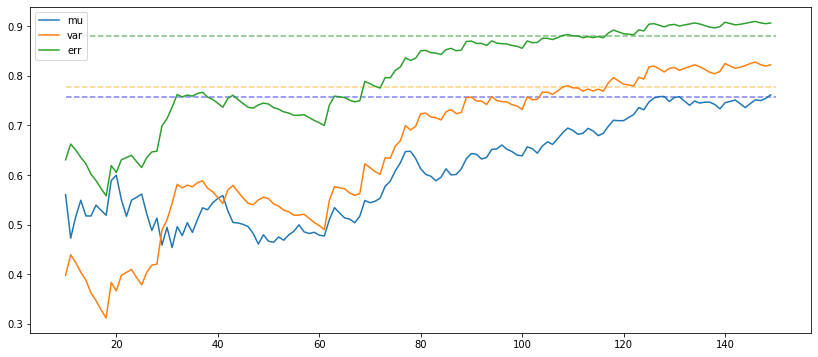

In [51]:
plt_samples()

### 2.3 Visualizing distributions

Knowing about the first two moments of a distribution is nice, but does not tell everything about a distribution. We can visualize how the observation values are distributed using a **histogram**. For this, we group the values into classes and count the number of occurences in each class. This process is called **binning**. There are tons of publications about binning.